# Dynamics lineshapes

In [1]:
import sympy as sp
from ampform.kinematics.phasespace import Kallen
from ampform_dpd.dynamics import (
    BlattWeisskopf,
    BreitWignerMinL,
    BuggBreitWigner,
    EnergyDependentWidth,
    FlattéSWave,
    P,
    Q,
)
from ampform_dpd.io import cached
from polarimetry.lhcb import load_three_body_decay
from polarimetry.lhcb import load_three_body_decay
from polarimetry.lhcb.particle import Σ, K, Λc, load_particles, p, π
from polarimetry.io import display_doit, display_latex
from polarimetry.lhcb.dynamics import (
    formulate_flatte_1405,
    formulate_breit_wigner
)
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
z = sp.Symbol("z", positive=True)
L = sp.Symbol("L", integer=True, nonnegative=True)
display_doit(BlattWeisskopf(z, L))

<IPython.core.display.Math object>

In [3]:
x, y, z = sp.symbols("x:z")
display_doit(Kallen(x, y, z))

<IPython.core.display.Math object>

In [4]:
s, m0, mi, mj, mk = sp.symbols("s m0 m_i:k", nonnegative=True)
display_doit(P(s, mi, mj))
display_doit(Q(s, m0, mk))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:
R = sp.Symbol("R")
l_R = sp.Symbol("l_R", integer=True, positive=True)
m, Γ0, m1, m2 = sp.symbols("m Γ0 m1 m2", nonnegative=True)
display_doit(EnergyDependentWidth(s, m, Γ0, m1, m2, l_R, R))

<IPython.core.display.Math object>

## Relativistic Breit-Wigner

In [6]:
m_top, m_spec = sp.symbols(R"m_\mathrm{top} m_\mathrm{spectator}")
R_dec, R_prod = sp.symbols(R"R_\mathrm{res} R_{\Lambda_c}")
l_Λc = sp.Symbol(R"l_{\Lambda_c}", integer=True, positive=True)
display_doit(BreitWignerMinL(s, m_top, m_spec, m, Γ0, m1, m2, l_R, l_Λc, R_dec, R_prod))

<IPython.core.display.Math object>

## Bugg Breit-Wigner

In [7]:
mKπ, m0, Γ0, mK, mπ, γ = sp.symbols(R"m_{K\pi} m0 Gamma0 m_K m_pi gamma")
bugg = BuggBreitWigner(mKπ**2, m0, Γ0, mK, mπ, γ)
q = P(mKπ**2, mK, mπ)
s_A = sp.Symbol("s_A")
definitions = {
    s_A: mK**2 - mπ**2 / 2,
    q: q.evaluate(),
}
display_latex({bugg: bugg.evaluate().subs({v: k for k, v in definitions.items()})})
display_latex(definitions)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

One of the models uses a Bugg Breit-Wigner with an exponential factor:

In [8]:
q = Q(s, m0, m1)
alpha = sp.Symbol("alpha")
bugg * sp.exp(-alpha * q**2)

exp(-alpha*Q(s, m0, m1)**2)*BuggBreitWigner(m_{K\pi}**2, m0, Gamma0, m_K, m_pi, gamma)

## Flatté for S-waves

In [9]:
Γ1, Γ2, m1, m2, mπ, mΣ = sp.symbols("Gamma1 Gamma2 m1 m2 m_pi m_Sigma")
display_doit(FlattéSWave(s, m, (Γ1, Γ2), (m1, m2), (mπ, mΣ)))

<IPython.core.display.Math object>

where, in this analysis, we couple the $\Lambda(1405)$ resonance to the channel $\Lambda(1405) \to \Sigma^-\pi^+$.

## Get decay chain

In [10]:
particles = load_particles("../../data/particle-definitions.yaml")

In [11]:
decay= load_three_body_decay(["L(1405)"], particles, min_ls= False)

In [12]:
for i, chain in enumerate(decay.chains):
    print(i, chain.incoming_ls, chain.outgoing_ls)

0 LSCoupling(L=0, S=1/2) LSCoupling(L=0, S=1/2)
1 LSCoupling(L=1, S=1/2) LSCoupling(L=0, S=1/2)


In [13]:
extracted_expr_chain0, params_chain0= formulate_flatte_1405(decay.chains[0])
extracted_expr_chain1, params_chain1= formulate_flatte_1405(decay.chains[1])

In [14]:
extracted_expr_chain1

BlattWeisskopf(R_{\Lambda_c}*Q(sigma2, m0, m_{\pi^+}), 1)*FlattéSWave(sigma2, m_{L(1405)}, (\Gamma_{L(1405) \to K^- p}, \Gamma_{L(1405) \to \pi^+ \Sigma^-}), (m3, m1), (m_{\pi^+}, m_{\Sigma^-}))*Q(sigma2, m0, m_{\pi^+})/(BlattWeisskopf(R_{\Lambda_c}*Q(m_{L(1405)}**2, m0, m_{\pi^+}), 1)*Q(m_{L(1405)}**2, m0, m_{\pi^+}))

In [15]:
flatte_function_chain0 = cached.lambdify(
    extracted_expr_chain0.doit(),
    parameters=params_chain0,
    backend="jax",
)
flatte_function_chain1 = cached.lambdify(
    extracted_expr_chain1.doit(),
    parameters=params_chain1,
    backend="jax",
)

AttributeError: 'ThreeBodyDecay' object has no attribute 'chain'

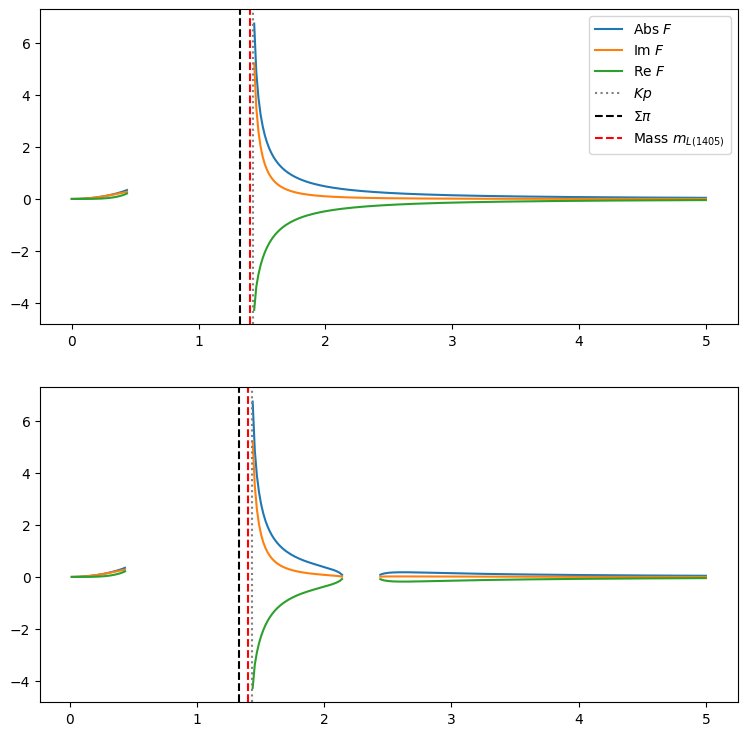

In [22]:
fig, axes = plt.subplots(nrows=2,figsize=(9, 9))
ax0, ax1 = axes 
x= np.linspace(0,5,300)
ax0.plot(x, np.abs(flatte_function_chain0({"sigma2": x**2})), label=R"Abs $F$")
ax0.plot(x, flatte_function_chain0({"sigma2": x**2}).imag, label=R"Im $F$")
ax0.plot(x, flatte_function_chain0({"sigma2": x**2}).real, label=R"Re $F$")
ax0.axvline(
    K.mass + p.mass,
    color="gray",
    linestyle="dotted",
    label=R"$K p$",
)
ax0.axvline(
    Σ.mass + π.mass,
    color="black",
    linestyle="--",
    label=R"$\Sigma \pi$",
)
ax0.axvline(
    flatte_function_chain0.parameters['m_{L(1405)}'],
    color="red",
    linestyle="--",
    label=R"Mass $m_{L(1405)}$",
)
ax0.legend()

ax1.plot(x, np.abs(flatte_function_chain1({"sigma2": x**2})), label=R"Abs $F$")
ax1.plot(x, flatte_function_chain1({"sigma2": x**2}).imag, label=R"Im $F$")
ax1.plot(x, flatte_function_chain1({"sigma2": x**2}).real, label=R"Re $F$")
ax1.axvline(
    K.mass + p.mass,
    color="gray",
    linestyle="dotted",
    label=R"$K p$",
)
ax1.axvline(
    Σ.mass + π.mass,
    color="black",
    linestyle="--",
    label=R"$\Sigma \pi$",
)
ax1.axvline(
    flatte_function_chain0.parameters['m_{L(1405)}'],
    color="red",
    linestyle="--",
    label=R"Mass $m_{L(1405)}$",
)
ax1.set_title(f"Decay chain 1, production {decay.chain[1].incoming_ls}, decay {chain[1].outgoing_ls}")
ax1.legend()
plt.show()